# 9 - Predições das matrículas

Para as matrículas, deseja-se atingir uma meta em relação à população. É possível prever como o número de matrículas vai crescer, mas a meta em relação à população precisa da estimativa da população para acontecer. 

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
dados_educ_pop = pd.read_csv('dados/dados_educ_pop.csv', sep = ',', parse_dates=['ANO_MES'], index_col='ANO_MES', date_parser=dateparse) 

# Só precisamos do distrito e da matrícula, para esse caso
dados_matricula = dados_educ_pop[['DISTRITO', 'MAT_CRECHE']]

Usando o modelo de predição ARIMA, sigla para Média móvel integrada autoregressiva, que forneceu o menor erro médio nos testes, vamos prever como as matrículas vão se comportar.

/usr/local/lib/python3.6/dist-packages/statsmodels-0.10.0.dev0+868.g14fb572ce-py3.6-linux-x86_64.egg/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels-0.10.0.dev0+868.g14fb572ce-py3.6-linux-x86_64.egg/statsmodels/tsa/statespace/sarimax.py:960: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels-0.10.0.dev0+868.g14fb572ce-py3.6-linux-x86_64.egg/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


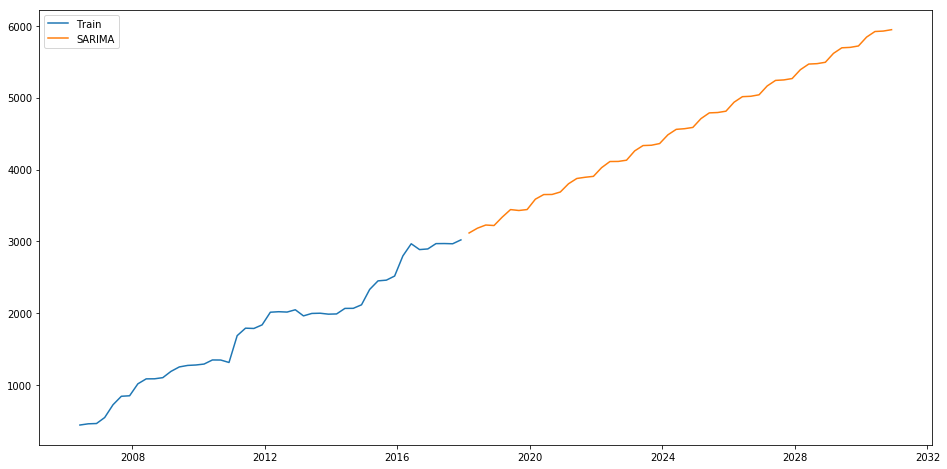

In [61]:
import statsmodels.api as sm

distrito = "PENHA"
dados_matricula = dados_matricula[dados_matricula['DISTRITO'] == distrito]

fit1 = sm.tsa.statespace.SARIMAX(dados_matricula.MAT_CRECHE, order=(2, 1, 4),seasonal_order=(0,1,1,4)).fit()
y_hat_avg = fit1.predict(start="2018-03-01", end="2030-12-01", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(dados_matricula.MAT_CRECHE, label='Train')
plt.plot(y_hat_avg, label='SARIMA')
plt.legend(loc='best')
plt.show()

Como não temos uma estimativa da população, vamos utilizar a média entre 1995 e 2018.

In [139]:
dados_pop = pd.read_csv('dados/populacao2.csv', sep = ';', encoding = 'ISO-8859-1')

dados_pop = dados_pop[["Localidades", "População de 0 a 3 Anos"]]
dados_pop.columns = ['DISTRITO', 'TOTAL']

dados_pop = dados_pop.groupby(['DISTRITO'])['TOTAL'].mean().to_frame().reset_index()

pop = dados_pop[dados_pop['DISTRITO'] == "Penha"]['TOTAL'].values[0]
meta = 0.8
atingiu = False
for index, element in y_hat_avg.iteritems():
    if element/pop >= meta:
        data = str(index)
        print(distrito + " - " + data[5:7] + '/' + data[:4])
        atingiu = True
        break
if not atingiu:
        print("O distrito " + distrito + " só vai ter atingir a meta a partir de 2031.")

Penha - 06/2026
